# Example 1a: Harmonic trap - Training of DeepCalib

Example code to train DeepCalib to determine the stiffness of a Brownian particle system in a harmonic trap.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

## 2. DEFINE TRAJECTORY SIMULATION 
<a id="sec2"></a>

Here the function that simulates the motion of the Brownian particle in the force field under consideration is defined. Specifically, in this case, we consider a Brownian particle in a harmonic force field, and the motion of the particle depends on the the trap stiffness k.

This file is used to reproduce results that are shown in Fig.1 and generate the pretrained network "DeepCalib_Example 1a.h5" that is going to be needed to execute Example 1b.

Comments:
1. The function that simulates the trajectories must be called <strong>simulate_trajectory</strong>.
2. Lambda functions <strong>scale_inputs</strong>, <strong>rescale_inputs</strong>, <strong>scale_targets</strong>, and <strong>rescale_targets</strong> must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [2]:
### Physical parameters 
from math import pi
R = 1e-7                   # Radius of the Brownian particle [m]
eta = 0.001                # Viscosity of the medium [kg m^-1 s^-1]
T = 300                    # Temperature [K]
k0 = 10                    # Reference stiffness [fN \mu m ^-1]
gamma0 = 6 * pi * eta * R  # Reference friction coefficient [kg s^-1]

### Simulation parameters
N = 1000                   # Number of samples of the trajectory
Dt = 1e-2                  # Timestep 
oversampling = 5           # Simulation oversampling
offset = 1000              # Number of equilibration timesteps

### Define functions to scale and rescale inputs
scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units

### Define function to scale and rescale targets
from numpy import log
from numpy import exp
scale_targets = lambda k: log(k / k0)                               # Scales targets to order 1
rescale_targets = lambda scaled_k: exp(scaled_k) * k0               # Inverse of targets_scaling

### Define the simulate_trajectory function

def simulate_trajectory(batch_size=32, 
                        T=T,
                        k0=k0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset, 
                        scale_inputs=scale_inputs, 
                        scale_targets=scale_targets):
    
    """Simulates a Brownian particle in a harmonic trap
    
    Inputs:
    
    T:              temperature of the environment
    k0:             center of the stiffness range
    gamma0:         friction coefficient
    N:              number of trajectory data points
    Dt:             measurement period
    oversampling:   oversampling from the simulation time step (to calculate dt)
    offset:         steps of the simulation before starting to save the trajectory
    scale_inputs:   inputs scale function for the network, to normalize it comparable to 1 
    scale_targets:  targets scale function for the network, to normalize it comparable to 1
        
    Outputs:
    
    inputs: the inputs for the network, these are trajectories that have the following features: 
            
            inputs.names:          names of the input trajectory variables ('x', 'y' etc)
            inputs.values:         values of the inputs in SI units
            inputs.scalings:       short description of the scaling function for the inputs ('x*1e6' etc)
            inputs.scaled_values:  scaled values of the inputs to be passed to the network for training
            
    targets: the expected ground truth measurements for the trajectory that have following features: 
            
            targets.names:          names of the targets to be measures ('k' etc)
            targets.values:         values of the ground truth targets in SI units
            targets.scalings:       short description of the scaling function for the targets ('log(k/k0)' etc)
            targets.scaled_values:  scaled values of the ground truth targets to be passed to the network for training      
    """  

    import numpy as np
    from scipy.constants import Boltzmann as kB
    from math import pi
    from math import sqrt
    from numpy.random import randn as gauss
    from numpy.random import rand as uniform
   
    ### Randomize trajectory parameters
    
    k = k0 * (10**(uniform(batch_size) * 3 - 1.5))     # Generates random stiffness values that are uniformly distributed in log scale
    gamma = gamma0 * (uniform(batch_size) * .1 + .95)  # Marginal randomization of friction coefficient to tolarate small changes

    ### Simulate
    
    dt = Dt / oversampling                 # time step of the simulation
    x = np.zeros((batch_size, N))          # initialization of the x array
    D = kB * T / gamma                     # diffusion coefficient
    C1 = -k *1e-9 / gamma * dt                   # drift coefficient of the Langevin equation
    C3 = np.sqrt(2 * D * dt)               # random walk coefficient of the Langevin equation
    X = x[:, 0]
    n = 0
    
    for t in range(offset):                      # Offset (for some prerun before running)
        X = X + C1 * X + C3 * gauss(batch_size)
        
    for t in range(N * oversampling):            # Simulation                
        X = X + C1 * X + C3 * gauss(batch_size)
        if t % oversampling == 0:                # We save every oversampling^th values 
            x[:, n] = X 
            n += 1
    
    # Normalize trajectory and targets
    
    inputs = DeepCalib.trajectory(
        names=['x'],  
        values=x, 
        scalings=['x [\u03BCm]'], 
        scaled_values=scale_inputs(x))
    
    targets = DeepCalib.targets(
        names=['k [fN/\u03BCm]'], 
        values=k,
        scalings=['log(k / k0)'], 
        scaled_values=scale_targets(k))    
    
    return inputs, targets

## 3. CHECK TRAJECTORY SIMULATION

Checks the results of the function to simulate the trajectories by plotting some examples in rescaled units. 

Have a look at the trajectories and check if they match your system, and keep an eye on different trajectories and make sure your scaled units vary in the order of 1, i.e, neither too small (0.01 or smaller) nor too large (100 or larger)

The parameter <strong>number_of_images_to_show</strong> determines the number of trajectories that are plotted.

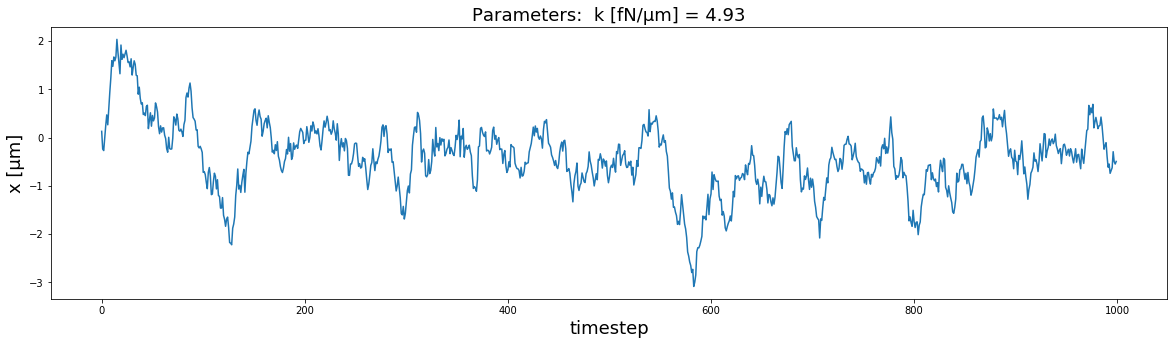

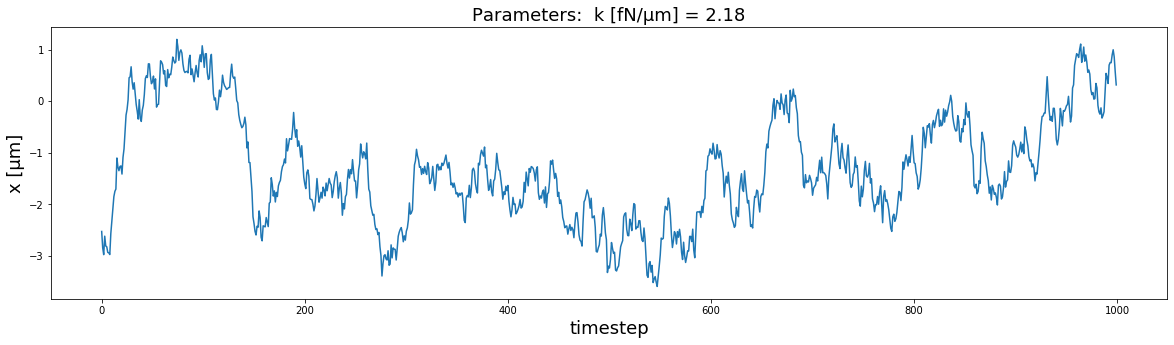

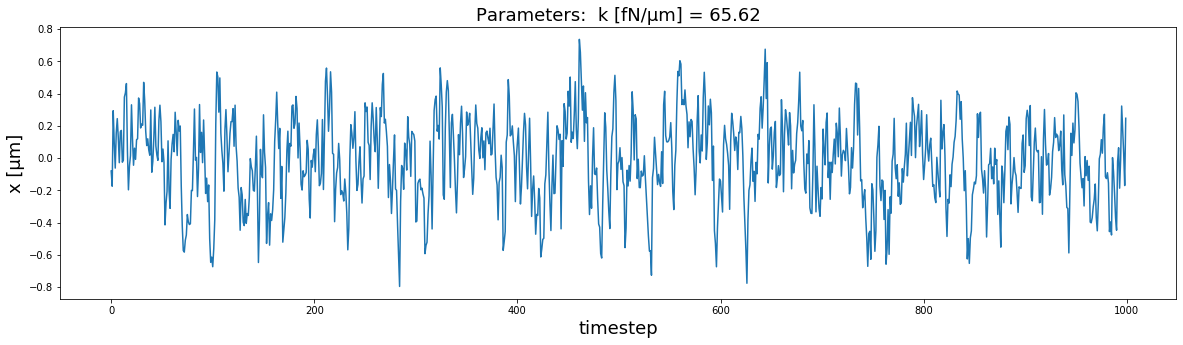

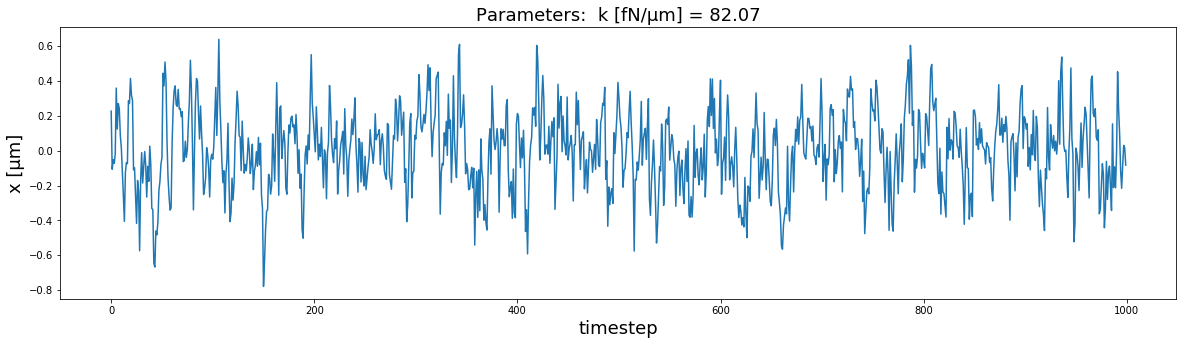

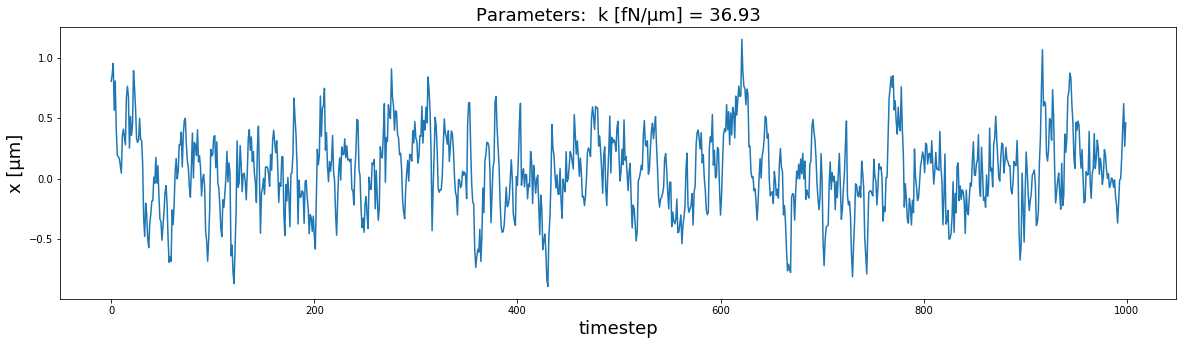

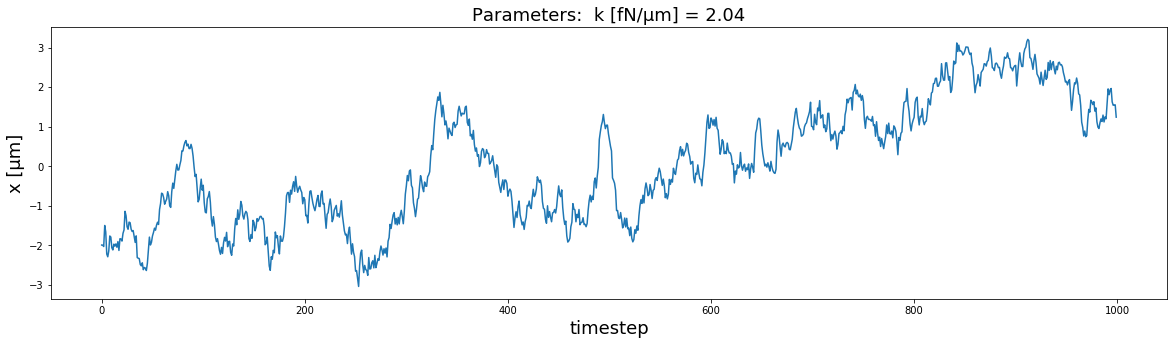

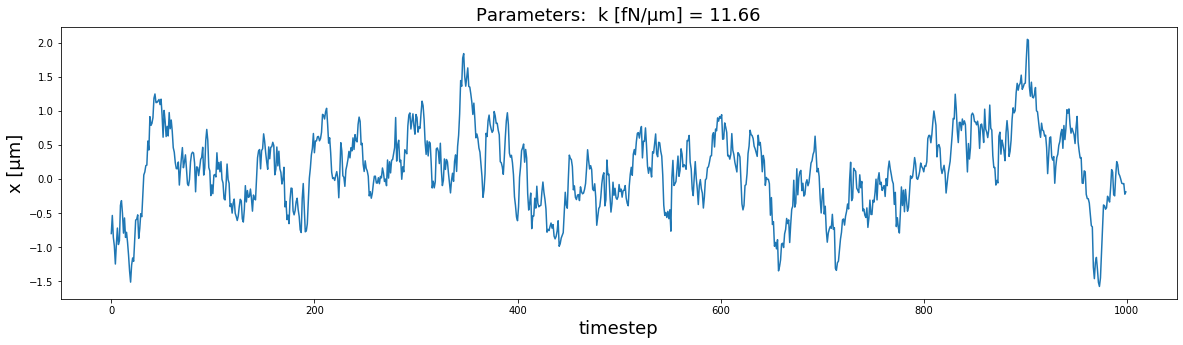

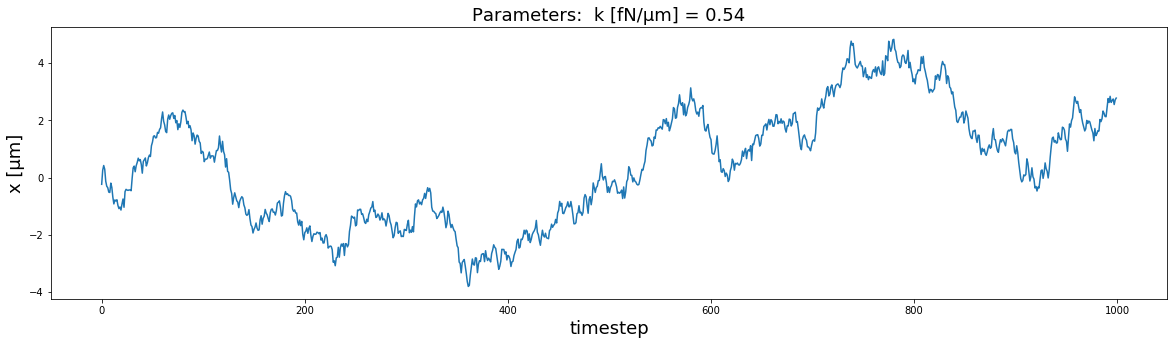

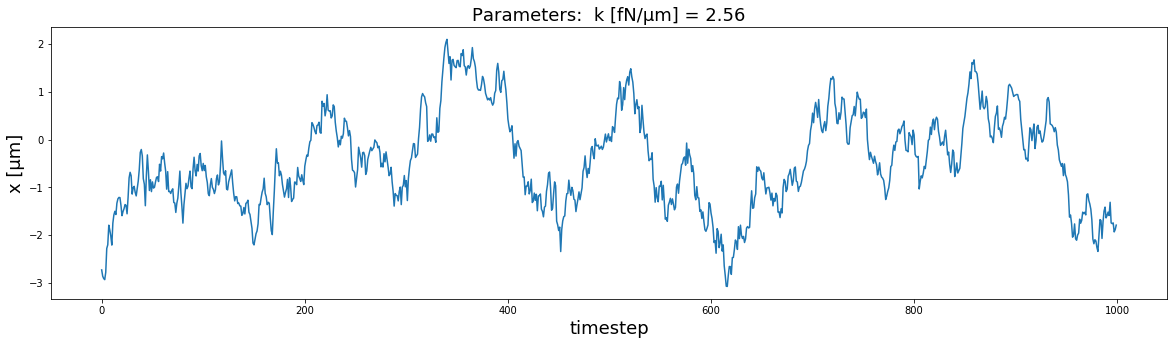

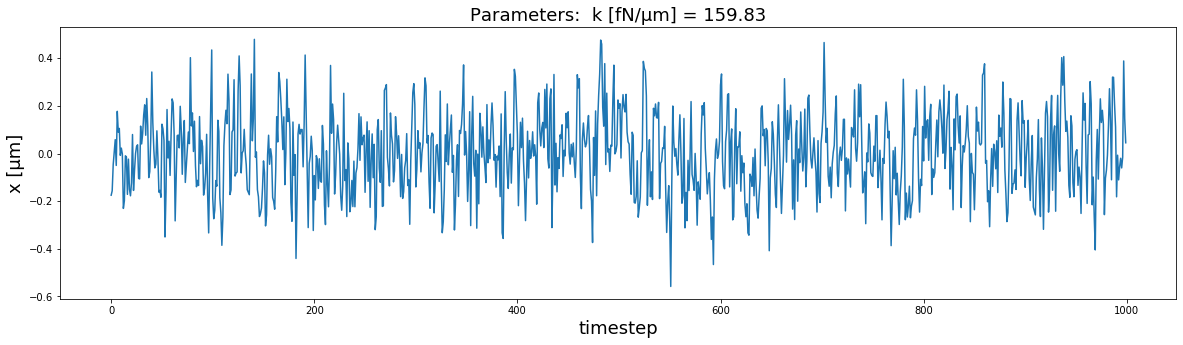

In [3]:
### Show some examples of simulated trajectories

number_of_trajectories_to_show = 10
%matplotlib inline
DeepCalib.plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

## 4. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of LSTM layers.
3. The parameter <strong>number_of_outputs</strong> determines the number of outputs, i.e. the number of force field parameters to be estimated.

In [6]:
### Define parameters of the deep learning network
input_shape = (20, 50)      
lstm_layers_dimensions = (1000, 250, 50)
number_of_outputs = 1

### Create deep learning network
network = DeepCalib.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs)

### Print deep learning network summary
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 1000)          4204000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 250)           1251000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
output (Dense)               (None, 1)                 51        
Total params: 5,515,251
Trainable params: 5,515,251
Non-trainable params: 0
_________________________________________________________________


## 5. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of trajectories used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [7]:
### Define parameters of the training
sample_sizes = (32, 128, 512, 2048)
iteration_numbers = (1001, 1001, 1001, 2001)
verbose = .1                    

### Training
training_history = DeepCalib.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size     32   iteration number      1   MSE     3.4480   MAE     1.5706   Time 4950.638294 ms
Sample size     32   iteration number     11   MSE     0.7324   MAE     0.7497   Time 107.949018 ms
Sample size     32   iteration number     21   MSE     0.4827   MAE     0.5501   Time 106.871605 ms
Sample size     32   iteration number     31   MSE     0.4117   MAE     0.5009   Time 108.043909 ms
Sample size     32   iteration number     41   MSE     0.2653   MAE     0.4318   Time 116.273880 ms
Sample size     32   iteration number     51   MSE     0.2784   MAE     0.4105   Time 106.824636 ms
Sample size     32   iteration number     61   MSE     0.2289   MAE     0.4020   Time 108.572006 ms
Sample size     32   iteration number     71   MSE     0.2677   MAE     0.3815   Time 113.693476 ms
Sample size     32   iteration number     81   MSE     0.2203   MAE     0.3974   Time 110.285759 ms
Sample size     32   iteration number     91   MSE     0.1720   MAE     0.3497   Time 107.877016 ms

Sample size     32   iteration number    821   MSE     0.1946   MAE     0.2644   Time 114.778996 ms
Sample size     32   iteration number    831   MSE     0.1683   MAE     0.2886   Time 109.090805 ms
Sample size     32   iteration number    841   MSE     0.1127   MAE     0.2614   Time 109.374046 ms
Sample size     32   iteration number    851   MSE     0.1481   MAE     0.3125   Time 108.285189 ms
Sample size     32   iteration number    861   MSE     0.1077   MAE     0.2423   Time 109.073400 ms
Sample size     32   iteration number    871   MSE     0.1397   MAE     0.2552   Time 103.258371 ms
Sample size     32   iteration number    881   MSE     0.2482   MAE     0.3395   Time 107.571125 ms
Sample size     32   iteration number    891   MSE     0.0746   MAE     0.1986   Time 107.233047 ms
Sample size     32   iteration number    901   MSE     0.0967   MAE     0.2416   Time 107.018471 ms
Sample size     32   iteration number    911   MSE     0.0741   MAE     0.2244   Time 105.915546 ms


Sample size    128   iteration number    631   MSE     0.1444   MAE     0.2579   Time 150.013208 ms
Sample size    128   iteration number    641   MSE     0.1196   MAE     0.2253   Time 156.994820 ms
Sample size    128   iteration number    651   MSE     0.0928   MAE     0.1994   Time 155.798912 ms
Sample size    128   iteration number    661   MSE     0.0986   MAE     0.2203   Time 152.577877 ms
Sample size    128   iteration number    671   MSE     0.0833   MAE     0.2073   Time 156.449080 ms
Sample size    128   iteration number    681   MSE     0.0825   MAE     0.1984   Time 154.718161 ms
Sample size    128   iteration number    691   MSE     0.0942   MAE     0.2128   Time 151.053905 ms
Sample size    128   iteration number    701   MSE     0.0780   MAE     0.1967   Time 166.045189 ms
Sample size    128   iteration number    711   MSE     0.1657   MAE     0.2657   Time 156.754255 ms
Sample size    128   iteration number    721   MSE     0.1118   MAE     0.2352   Time 161.048174 ms


Sample size    512   iteration number    441   MSE     0.1075   MAE     0.2273   Time 352.936029 ms
Sample size    512   iteration number    451   MSE     0.1013   MAE     0.2151   Time 352.892160 ms
Sample size    512   iteration number    461   MSE     0.1075   MAE     0.2144   Time 353.129625 ms
Sample size    512   iteration number    471   MSE     0.1024   MAE     0.2096   Time 355.608225 ms
Sample size    512   iteration number    481   MSE     0.1057   MAE     0.2130   Time 347.187996 ms
Sample size    512   iteration number    491   MSE     0.1062   MAE     0.2183   Time 347.598314 ms
Sample size    512   iteration number    501   MSE     0.1204   MAE     0.2265   Time 346.058607 ms
Sample size    512   iteration number    511   MSE     0.1075   MAE     0.2208   Time 350.479364 ms
Sample size    512   iteration number    521   MSE     0.0896   MAE     0.2013   Time 345.561504 ms
Sample size    512   iteration number    531   MSE     0.0853   MAE     0.2021   Time 348.217964 ms


Sample size   2048   iteration number    251   MSE     0.1025   MAE     0.2138   Time 1094.253778 ms
Sample size   2048   iteration number    261   MSE     0.1061   MAE     0.2176   Time 1101.514101 ms
Sample size   2048   iteration number    271   MSE     0.0935   MAE     0.2077   Time 1093.904257 ms
Sample size   2048   iteration number    281   MSE     0.1017   MAE     0.2157   Time 1113.891840 ms
Sample size   2048   iteration number    291   MSE     0.1065   MAE     0.2174   Time 1097.111940 ms
Sample size   2048   iteration number    301   MSE     0.1009   MAE     0.2125   Time 1096.329212 ms
Sample size   2048   iteration number    311   MSE     0.1002   MAE     0.2128   Time 1093.700647 ms
Sample size   2048   iteration number    321   MSE     0.0942   MAE     0.2073   Time 1100.288153 ms
Sample size   2048   iteration number    331   MSE     0.1137   MAE     0.2233   Time 1093.962431 ms
Sample size   2048   iteration number    341   MSE     0.1100   MAE     0.2241   Time 1100.

Sample size   2048   iteration number   1071   MSE     0.0984   MAE     0.2073   Time 1099.051237 ms
Sample size   2048   iteration number   1081   MSE     0.0985   MAE     0.2096   Time 1097.874880 ms
Sample size   2048   iteration number   1091   MSE     0.1101   MAE     0.2190   Time 1098.635912 ms
Sample size   2048   iteration number   1101   MSE     0.1070   MAE     0.2146   Time 1101.925850 ms
Sample size   2048   iteration number   1111   MSE     0.1080   MAE     0.2155   Time 1103.010416 ms
Sample size   2048   iteration number   1121   MSE     0.0971   MAE     0.2132   Time 1107.691765 ms
Sample size   2048   iteration number   1131   MSE     0.1013   MAE     0.2087   Time 1102.984190 ms
Sample size   2048   iteration number   1141   MSE     0.0954   MAE     0.2080   Time 1100.646973 ms
Sample size   2048   iteration number   1151   MSE     0.0972   MAE     0.2076   Time 1099.801540 ms
Sample size   2048   iteration number   1161   MSE     0.1080   MAE     0.2150   Time 1101.

Sample size   2048   iteration number   1891   MSE     0.1030   MAE     0.2143   Time 1084.010839 ms
Sample size   2048   iteration number   1901   MSE     0.1185   MAE     0.2223   Time 1085.835695 ms
Sample size   2048   iteration number   1911   MSE     0.1076   MAE     0.2150   Time 1093.058348 ms
Sample size   2048   iteration number   1921   MSE     0.0982   MAE     0.2117   Time 1084.591150 ms
Sample size   2048   iteration number   1931   MSE     0.1097   MAE     0.2175   Time 1085.832834 ms
Sample size   2048   iteration number   1941   MSE     0.1030   MAE     0.2135   Time 1078.613281 ms
Sample size   2048   iteration number   1951   MSE     0.1023   MAE     0.2072   Time 1101.624012 ms
Sample size   2048   iteration number   1961   MSE     0.0936   MAE     0.2043   Time 1097.885370 ms
Sample size   2048   iteration number   1971   MSE     0.1070   MAE     0.2166   Time 1098.147631 ms
Sample size   2048   iteration number   1981   MSE     0.1019   MAE     0.2133   Time 1103.

## 6. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

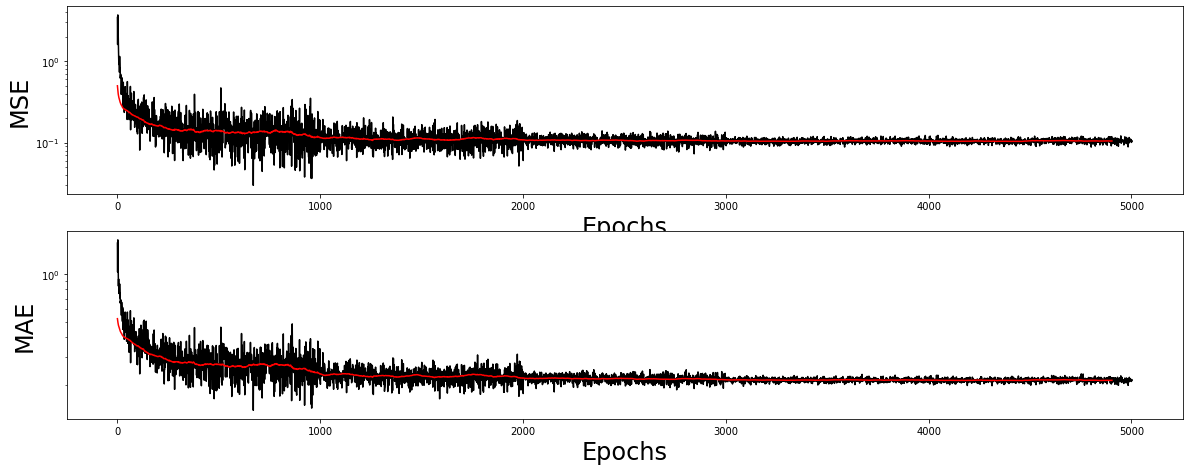

In [8]:
### Plot learning performance
number_of_timesteps_for_average = 100
DeepCalib.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 7. TEST DEEP LEARNING NETWORK ON NEW SIMULATED TRAJECTORIES

The deep learning network is tested on new simulated trajectories (parameters are defined in [section 2](#sec2)). The predicted values of the targets are plotted as function of their ground-truth values both in scaled and physical units.

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.

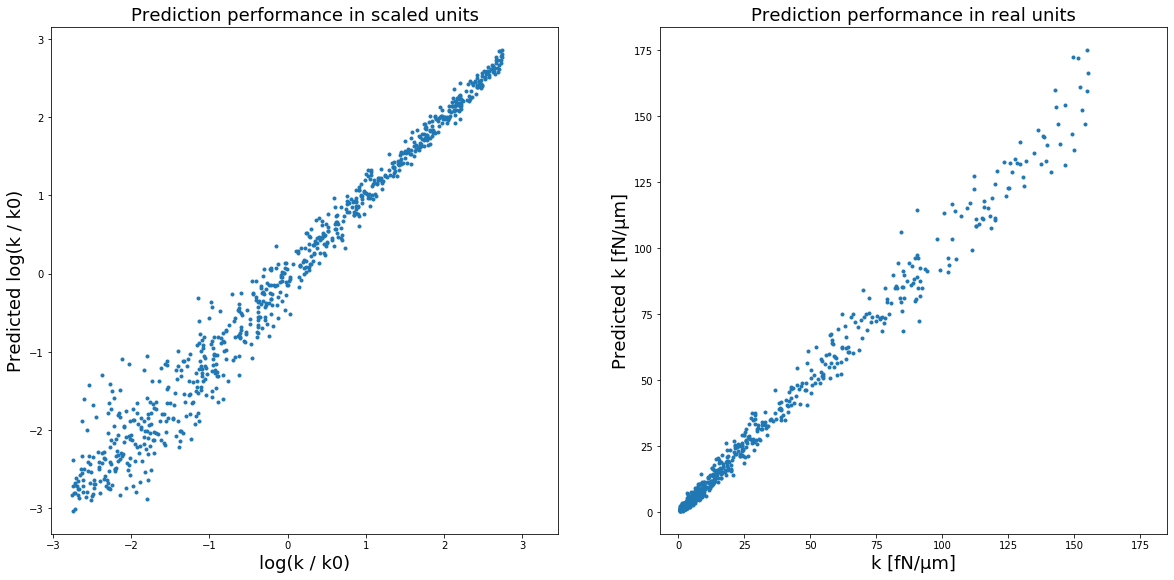

In [9]:
### Test the predictions of the deep learning network on some generated trajectories
number_of_predictions_to_show = 1000

%matplotlib inline
DeepCalib.plot_test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

## 9. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepCalib is running.

In [8]:
save_file_name = 'Network_Example_1a.h5'
network.save(save_file_name)